# Comparing the baseline dataset vs our feature engineered dataset

In this notebook, we're comparing the baseline dataset that was provided to use at the beginning of the hackathon with the dataset that we created and tailored with some new features. We will be comparing the two best models :

- QRF
- XGBQRF


In [63]:
import os
import sys

import numpy as np
import pandas as pd
from timeit import default_timer as timer 

from quantile_forest import RandomForestQuantileRegressor
from codecarbon import EmissionsTracker 

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "..", "..")))

from src.utils.model import (
    split_dataset,
    compare_models_per_station,
    XGBQRFModel,
)

from src.utils.helpers import check_columns_exist, get_y_train

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
ALPHA = 0.1
TIME_VALIDATION = "2000-01-01 00:00:00"
SEED = 42
NUMBER_OF_WEEK = 4  # Number of weeks to predict one model is trained per week
QUANTILES = [ALPHA / 2, 0.5, 1 - ALPHA / 2]

INPUT_DIR = os.path.join("..", "..", "..", "data", "input")
BASELINE_DATASET_NAME = "dataset_baseline.csv"
CUSTOM_DATASET_NAME = "dataset_custom.csv"
BASELINE_DATASET_PATH = os.path.join(INPUT_DIR, BASELINE_DATASET_NAME)
CUSTOM_DATASET_PATH = os.path.join(INPUT_DIR, CUSTOM_DATASET_NAME)
DATASET_TYPES = ["baseline", "custom"]
DATASETS = {}

best_params_qrf = {
    "n_estimators": 130,
    "min_samples_split": 30,
    "min_samples_leaf": 20,
    "max_features": None,
    "max_depth": 30,
    "bootstrap": True,
}

best_params_xgb = {
    "subsample": 0.6,
    "n_estimators": 300,
    "min_child_weight": 5,
    "max_depth": 5,
    "learning_rate": 0.05,
    "gamma": 0.1,
    "colsample_bytree": 0.8,
}

# Will be used for comparison later on
summary = {}

In [65]:
for dataset_type in DATASET_TYPES:
    if dataset_type == "baseline":
        dataset_path = BASELINE_DATASET_PATH
    else:
        dataset_path = CUSTOM_DATASET_PATH

    # Load dataset
    dataset = pd.read_csv(dataset_path)

    # Check if columns exist
    check_columns_exist(dataset, ["ObsDate", "station_code"])

    # Set index to ObsDate
    dataset = dataset.set_index("ObsDate")

    # Split dataset into train and test sets
    train_split, test_split, eval_split = split_dataset(dataset, 0.75, TIME_VALIDATION)

    # Get X and y for training and testing
    x_train, y_train = get_y_train(train_split.drop(columns=["station_code"]))
    x_test, y_test = get_y_train(test_split.drop(columns=["station_code"]))
    x_eval, y_eval = get_y_train(eval_split)

    summary[dataset_type] = {}

    DATASETS[dataset_type] = {
        "x_train": x_train,
        "y_train": y_train,
        "x_test": x_test,
        "y_test": y_test,
        "x_eval": x_eval,
        "y_eval": y_eval,
    }

## Training


In [66]:
for dataset_type in DATASET_TYPES:
    summary[dataset_type]["QRF"] = {}
    summary[dataset_type]["XGBQRF"] = {}
    summary[dataset_type]["train_times"] = {}
    summary[dataset_type]["train_times"]["QRF"] = []
    summary[dataset_type]["train_times"]["XGBQRF"] = []
    summary[dataset_type]["emissions"] = {}
    summary[dataset_type]["emissions"]["QRF"] = []
    summary[dataset_type]["emissions"]["XGBQRF"] = []
    summary[dataset_type]["XGBQRF"]["emissions"] = []
    summary[dataset_type]["n_cols"] = len(DATASETS[dataset_type]["x_train"].columns)
    for i in range(NUMBER_OF_WEEK):
        print(f"Training QRF week {i + 1}...")
        tracker = EmissionsTracker()
        qrf = RandomForestQuantileRegressor(**best_params_qrf, random_state=SEED)

        tracker.start()
        start = timer()
        qrf.fit(DATASETS[dataset_type]["x_train"], DATASETS[dataset_type]["y_train"][i])
        end = timer()
        summary[dataset_type]["emissions"]["QRF"].append(tracker.stop())

        summary[dataset_type]["train_times"]["QRF"].append(end - start)
        print(f"QRF week {i + 1} trained in {end - start:.2f} seconds")
        summary[dataset_type]["QRF"][i] = qrf

        print(f"Training XGB week {i + 1}...")
        xgb = XGBQRFModel(
            best_params_xgb, best_params_qrf, quantiles=QUANTILES, random_state=SEED
        )

        tracker.start()
        start = timer()
        xgb.fit(
            DATASETS[dataset_type]["x_train"],
            DATASETS[dataset_type]["y_train"][i],
            eval_set=[
                (
                    DATASETS[dataset_type]["x_test"],
                    DATASETS[dataset_type]["y_test"][i],
                )
            ],
        )
        end = timer()
        summary[dataset_type]["emissions"]["XGBQRF"].append(tracker.stop())

        summary[dataset_type]["train_times"]["XGBQRF"].append(end - start)
        print(f"XGB week {i + 1} trained in {end - start:.2f} seconds")
        summary[dataset_type]["XGBQRF"][i] = xgb

[codecarbon WARNING @ 21:51:33] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 21:51:33] Error while trying to count physical CPUs: [Errno 2] No such file or directory: 'lscpu'. Defaulting to 1.
[codecarbon INFO @ 21:51:33] [setup] RAM Tracking...
[codecarbon INFO @ 21:51:33] [setup] CPU Tracking...


Training QRF week 1...


[codecarbon WARNING @ 21:51:33] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon INFO @ 21:51:33] CPU Model on constant consumption mode: Apple M1
[codecarbon WARNING @ 21:51:33] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 21:51:33] [setup] GPU Tracking...
[codecarbon INFO @ 21:51:33] No GPU found.
[codecarbon INFO @ 21:51:33] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 21:51:33] >>> Tracker's metadata:
[codecarbon INFO @ 21:51:33]   Platform system: macOS-13.2.1-arm64-arm-64bit
[codecarbon INFO @ 21:51:33]   Python version: 3.12.8
[codecarbon INFO @ 21:51:33]   CodeCarbon version: 3.0.1
[codecarbon INFO @ 21:51:33]   Available RA

QRF week 1 trained in 55.15 seconds
Training XGB week 1...
Fitting XGB models
Fitting QRF model


[codecarbon INFO @ 21:52:40] Energy consumed for RAM : 0.000813 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 21:52:40] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 21:52:40] Energy consumed for All CPU : 0.001355 kWh
[codecarbon INFO @ 21:52:40] 0.002167 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:52:55] Energy consumed for RAM : 0.000825 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 21:52:55] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 21:52:55] Energy consumed for All CPU : 0.001375 kWh
[codecarbon INFO @ 21:52:55] 0.002201 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:53:10] Energy consumed for RAM : 0.000838 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 21:53:10] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 21:53:10] Energy consumed for All CPU : 0.001396 kWh
[codecarbon INFO @ 21:53:10] 0.002234 kWh of ele

XGB week 1 trained in 58.86 seconds
Training QRF week 2...


[codecarbon WARNING @ 21:53:31] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon INFO @ 21:53:31] CPU Model on constant consumption mode: Apple M1
[codecarbon WARNING @ 21:53:31] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 21:53:31] [setup] GPU Tracking...
[codecarbon INFO @ 21:53:31] No GPU found.
[codecarbon INFO @ 21:53:31] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 21:53:31] >>> Tracker's metadata:
[codecarbon INFO @ 21:53:31]   Platform system: macOS-13.2.1-arm64-arm-64bit
[codecarbon INFO @ 21:53:31]   Python version: 3.12.8
[codecarbon INFO @ 21:53:31]   CodeCarbon version: 3.0.1
[codecarbon INFO @ 21:53:31]   Available RA

QRF week 2 trained in 55.23 seconds
Training XGB week 2...
Fitting XGB models
Fitting QRF model


[codecarbon INFO @ 21:54:46] Energy consumed for RAM : 0.000913 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 21:54:46] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 21:54:46] Energy consumed for All CPU : 0.001521 kWh
[codecarbon INFO @ 21:54:46] 0.002434 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:55:01] Energy consumed for RAM : 0.000925 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 21:55:01] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 21:55:01] Energy consumed for All CPU : 0.001542 kWh
[codecarbon INFO @ 21:55:01] 0.002467 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:55:16] Energy consumed for RAM : 0.000938 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 21:55:16] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 21:55:16] Energy consumed for All CPU : 0.001563 kWh
[codecarbon INFO @ 21:55:16] 0.002501 kWh of ele

XGB week 2 trained in 56.17 seconds
Training QRF week 3...


[codecarbon WARNING @ 21:55:30] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon INFO @ 21:55:30] CPU Model on constant consumption mode: Apple M1
[codecarbon WARNING @ 21:55:30] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 21:55:30] [setup] GPU Tracking...
[codecarbon INFO @ 21:55:30] No GPU found.
[codecarbon INFO @ 21:55:30] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 21:55:30] >>> Tracker's metadata:
[codecarbon INFO @ 21:55:30]   Platform system: macOS-13.2.1-arm64-arm-64bit
[codecarbon INFO @ 21:55:30]   Python version: 3.12.8
[codecarbon INFO @ 21:55:30]   CodeCarbon version: 3.0.1
[codecarbon INFO @ 21:55:30]   Available RA

QRF week 3 trained in 52.09 seconds
Training XGB week 3...
Fitting XGB models
Fitting QRF model


[codecarbon INFO @ 21:56:31] Energy consumed for RAM : 0.001000 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 21:56:31] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 21:56:31] Energy consumed for All CPU : 0.001667 kWh
[codecarbon INFO @ 21:56:31] 0.002667 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:56:31] 0.000125 g.CO2eq/s mean an estimation of 3.9267473290054697 kg.CO2eq/year
[codecarbon INFO @ 21:56:46] Energy consumed for RAM : 0.001013 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 21:56:46] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 21:56:46] Energy consumed for All CPU : 0.001688 kWh
[codecarbon INFO @ 21:56:46] 0.002701 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:57:01] Energy consumed for RAM : 0.001025 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 21:57:01] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO 

XGB week 3 trained in 56.11 seconds
Training QRF week 4...


[codecarbon WARNING @ 21:57:20] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon INFO @ 21:57:20] CPU Model on constant consumption mode: Apple M1
[codecarbon WARNING @ 21:57:20] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 21:57:20] [setup] GPU Tracking...
[codecarbon INFO @ 21:57:20] No GPU found.
[codecarbon INFO @ 21:57:20] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 21:57:20] >>> Tracker's metadata:
[codecarbon INFO @ 21:57:20]   Platform system: macOS-13.2.1-arm64-arm-64bit
[codecarbon INFO @ 21:57:20]   Python version: 3.12.8
[codecarbon INFO @ 21:57:20]   CodeCarbon version: 3.0.1
[codecarbon INFO @ 21:57:20]   Available RA

QRF week 4 trained in 49.36 seconds
Training XGB week 4...
Fitting XGB models
Fitting QRF model


[codecarbon INFO @ 21:58:16] Energy consumed for RAM : 0.001088 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 21:58:16] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 21:58:16] Energy consumed for All CPU : 0.001813 kWh
[codecarbon INFO @ 21:58:16] 0.002901 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:58:31] Energy consumed for RAM : 0.001100 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 21:58:31] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 21:58:31] Energy consumed for All CPU : 0.001834 kWh
[codecarbon INFO @ 21:58:31] 0.002934 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:58:31] 0.000125 g.CO2eq/s mean an estimation of 3.9269291058520848 kg.CO2eq/year
[codecarbon INFO @ 21:58:46] Energy consumed for RAM : 0.001113 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 21:58:46] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO 

XGB week 4 trained in 54.14 seconds
Training QRF week 1...


[codecarbon WARNING @ 21:59:07] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon INFO @ 21:59:07] CPU Model on constant consumption mode: Apple M1
[codecarbon WARNING @ 21:59:07] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 21:59:07] [setup] GPU Tracking...
[codecarbon INFO @ 21:59:07] No GPU found.
[codecarbon INFO @ 21:59:07] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 21:59:07] >>> Tracker's metadata:
[codecarbon INFO @ 21:59:07]   Platform system: macOS-13.2.1-arm64-arm-64bit
[codecarbon INFO @ 21:59:07]   Python version: 3.12.8
[codecarbon INFO @ 21:59:07]   CodeCarbon version: 3.0.1
[codecarbon INFO @ 21:59:07]   Available RA

QRF week 1 trained in 28.64 seconds
Training XGB week 1...
Fitting XGB models
Fitting QRF model


[codecarbon INFO @ 21:59:46] Energy consumed for RAM : 0.001163 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 21:59:46] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 21:59:46] Energy consumed for All CPU : 0.001938 kWh
[codecarbon INFO @ 21:59:46] 0.003101 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:00:01] Energy consumed for RAM : 0.001175 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 22:00:01] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 22:00:01] Energy consumed for All CPU : 0.001959 kWh
[codecarbon INFO @ 22:00:01] 0.003134 kWh of electricity used since the beginning.
[codecarbon WARNING @ 22:00:07] Tracker already stopped !
[codecarbon INFO @ 22:00:07] Energy consumed for RAM : 0.000049 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 22:00:07] Delta energy consumed for CPU with constant : 0.000042 kWh, power : 5.0 W
[codecarbon INFO @ 22:00:07] Energy consumed for All CPU : 0.0

XGB week 1 trained in 30.54 seconds
Training QRF week 2...


[codecarbon WARNING @ 22:00:07] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon INFO @ 22:00:07] CPU Model on constant consumption mode: Apple M1
[codecarbon WARNING @ 22:00:07] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 22:00:07] [setup] GPU Tracking...
[codecarbon INFO @ 22:00:07] No GPU found.
[codecarbon INFO @ 22:00:07] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 22:00:07] >>> Tracker's metadata:
[codecarbon INFO @ 22:00:07]   Platform system: macOS-13.2.1-arm64-arm-64bit
[codecarbon INFO @ 22:00:07]   Python version: 3.12.8
[codecarbon INFO @ 22:00:07]   CodeCarbon version: 3.0.1
[codecarbon INFO @ 22:00:07]   Available RA

QRF week 2 trained in 27.53 seconds
Training XGB week 2...
Fitting XGB models
Fitting QRF model


[codecarbon INFO @ 22:00:46] Energy consumed for RAM : 0.001213 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 22:00:46] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 22:00:46] Energy consumed for All CPU : 0.002021 kWh
[codecarbon INFO @ 22:00:46] 0.003234 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:01:01] Energy consumed for RAM : 0.001225 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 22:01:01] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 22:01:01] Energy consumed for All CPU : 0.002042 kWh
[codecarbon INFO @ 22:01:01] 0.003267 kWh of electricity used since the beginning.
[codecarbon WARNING @ 22:01:08] Tracker already stopped !
[codecarbon INFO @ 22:01:08] Energy consumed for RAM : 0.000048 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 22:01:08] Delta energy consumed for CPU with constant : 0.000041 kWh, power : 5.0 W
[codecarbon INFO @ 22:01:08] Energy consumed for All CPU : 0.0

XGB week 2 trained in 29.60 seconds
Training QRF week 3...


[codecarbon WARNING @ 22:01:08] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon INFO @ 22:01:08] CPU Model on constant consumption mode: Apple M1
[codecarbon WARNING @ 22:01:08] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 22:01:08] [setup] GPU Tracking...
[codecarbon INFO @ 22:01:08] No GPU found.
[codecarbon INFO @ 22:01:08] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 22:01:08] >>> Tracker's metadata:
[codecarbon INFO @ 22:01:08]   Platform system: macOS-13.2.1-arm64-arm-64bit
[codecarbon INFO @ 22:01:08]   Python version: 3.12.8
[codecarbon INFO @ 22:01:08]   CodeCarbon version: 3.0.1
[codecarbon INFO @ 22:01:08]   Available RA

QRF week 3 trained in 26.23 seconds
Training XGB week 3...
Fitting XGB models
Fitting QRF model


[codecarbon INFO @ 22:01:46] Energy consumed for RAM : 0.001263 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 22:01:46] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 22:01:46] Energy consumed for All CPU : 0.002105 kWh
[codecarbon INFO @ 22:01:46] 0.003367 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:02:01] Energy consumed for RAM : 0.001275 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 22:02:01] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 22:02:01] Energy consumed for All CPU : 0.002126 kWh
[codecarbon INFO @ 22:02:01] 0.003401 kWh of electricity used since the beginning.
[codecarbon WARNING @ 22:02:04] Tracker already stopped !
[codecarbon INFO @ 22:02:04] Energy consumed for RAM : 0.000045 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 22:02:04] Delta energy consumed for CPU with constant : 0.000039 kWh, power : 5.0 W
[codecarbon INFO @ 22:02:04] Energy consumed for All CPU : 0.0

XGB week 3 trained in 28.20 seconds
Training QRF week 4...


[codecarbon WARNING @ 22:02:04] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon INFO @ 22:02:04] CPU Model on constant consumption mode: Apple M1
[codecarbon WARNING @ 22:02:04] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 22:02:04] [setup] GPU Tracking...
[codecarbon INFO @ 22:02:04] No GPU found.
[codecarbon INFO @ 22:02:04] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 22:02:04] >>> Tracker's metadata:
[codecarbon INFO @ 22:02:04]   Platform system: macOS-13.2.1-arm64-arm-64bit
[codecarbon INFO @ 22:02:04]   Python version: 3.12.8
[codecarbon INFO @ 22:02:04]   CodeCarbon version: 3.0.1
[codecarbon INFO @ 22:02:04]   Available RA

QRF week 4 trained in 26.24 seconds
Training XGB week 4...
Fitting XGB models
Fitting QRF model


[codecarbon INFO @ 22:02:46] Energy consumed for RAM : 0.001313 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 22:02:46] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 22:02:46] Energy consumed for All CPU : 0.002188 kWh
[codecarbon INFO @ 22:02:46] 0.003501 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:03:01] Energy consumed for RAM : 0.001325 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 22:03:01] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 22:03:01] Energy consumed for All CPU : 0.002209 kWh
[codecarbon INFO @ 22:03:01] 0.003534 kWh of electricity used since the beginning.
[codecarbon WARNING @ 22:03:02] Tracker already stopped !
[codecarbon INFO @ 22:03:02] Energy consumed for RAM : 0.000045 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 22:03:02] Delta energy consumed for CPU with constant : 0.000039 kWh, power : 5.0 W
[codecarbon INFO @ 22:03:02] Energy consumed for All CPU : 0.0

XGB week 4 trained in 28.07 seconds


## Evaluation


In [67]:
summary

{'baseline': {'QRF': {0: RandomForestQuantileRegressor(max_depth=30, max_features=None,
                                 min_samples_leaf=20, min_samples_split=30,
                                 n_estimators=130, random_state=42),
   1: RandomForestQuantileRegressor(max_depth=30, max_features=None,
                                 min_samples_leaf=20, min_samples_split=30,
                                 n_estimators=130, random_state=42),
   2: RandomForestQuantileRegressor(max_depth=30, max_features=None,
                                 min_samples_leaf=20, min_samples_split=30,
                                 n_estimators=130, random_state=42),
   3: RandomForestQuantileRegressor(max_depth=30, max_features=None,
                                 min_samples_leaf=20, min_samples_split=30,
                                 n_estimators=130, random_state=42)},
  'XGBQRF': {'emissions': [],
   0: <src.utils.model.XGBQRFModel at 0x29e137a40>,
   1: <src.utils.model.XGBQRFModel at 0x29

In [68]:
predictions = {}

for dataset_type in DATASET_TYPES:
    summary[dataset_type]["QRF"]["predictions"] = {}
    summary[dataset_type]["XGBQRF"]["predictions"] = {}
    predictions[dataset_type] = []
    for i in range(NUMBER_OF_WEEK):
        stations = DATASETS[dataset_type]["x_eval"]["station_code"].values
        x_eval = DATASETS[dataset_type]["x_eval"].drop(columns=["station_code"])
        y_eval = DATASETS[dataset_type]["y_eval"][i]
        qrf_predictions = summary[dataset_type]["QRF"][i].predict(
            x_eval, quantiles=QUANTILES
        )

        xgb_predictions = summary[dataset_type]["XGBQRF"][i].predict(x_eval)

        summary[dataset_type]["QRF"]["predictions"][i] = qrf_predictions
        summary[dataset_type]["XGBQRF"]["predictions"][i] = xgb_predictions

        predictions[dataset_type].append(
            {
                "model": "QRF",
                "prediction": qrf_predictions[:, 1],
                "dataset": dataset_type,
                "stations": stations,
                "prediction_interval": np.stack(
                    [qrf_predictions[:, 0], qrf_predictions[:, 2]], axis=1
                ),
            }
        )

        predictions[dataset_type].append(
            {
                "model": "XGBQRF",
                "prediction": xgb_predictions[:, 1],
                "dataset": dataset_type,
                "stations": stations,
                "prediction_interval": np.stack(
                    [xgb_predictions[:, 0], xgb_predictions[:, 2]], axis=1
                ),
            }
        )

## Results

### Training Time


<Axes: xlabel='model_type', ylabel='training_time'>

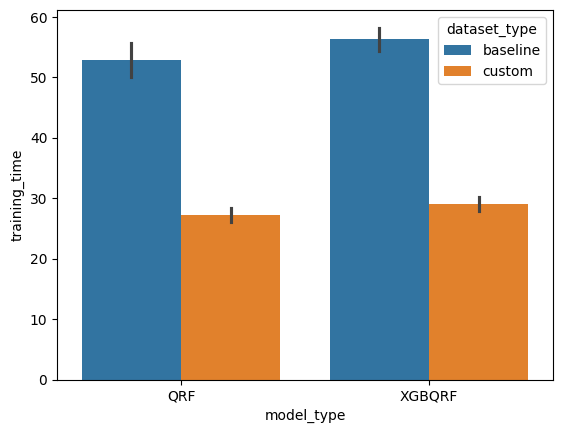

In [69]:
# Flatten into list of rows
rows = []
for dataset_type, dataset_data in summary.items():
    for model_type, times in dataset_data.get("train_times", {}).items():
        for time in times:
            rows.append(
                {
                    "dataset_type": dataset_type,
                    "model_type": model_type,
                    "training_time": time,
                }
            )

# Create DataFrame
train_time_df = pd.DataFrame(rows)

import seaborn as sns

sns.barplot(
    train_time_df,
    x="model_type",
    y="training_time",
    hue="dataset_type",
    errorbar="sd",
)

In [70]:
speedup = (
    train_time_df[train_time_df["dataset_type"] == "custom"]["training_time"].sum()
    / train_time_df[train_time_df["dataset_type"] == "baseline"]["training_time"].sum()
) * 100

print(f"Speedup with custom dataset: {speedup:.2f}%")

Speedup with custom dataset: 51.48%


In [71]:
baseline_train_time = train_time_df[train_time_df["dataset_type"] == "baseline"]
custom_train_time = train_time_df[train_time_df["dataset_type"] == "custom"]

print(
    f"Average baseline train time : {baseline_train_time['training_time'].mean():.2f} seconds +/- {baseline_train_time['training_time'].std():.2f} seconds"
)
print(
    f"Average custom train time : {custom_train_time['training_time'].mean():.2f} seconds +/- {custom_train_time['training_time'].std():.2f} seconds"
)

Average baseline train time : 54.64 seconds +/- 2.87 seconds
Average custom train time : 28.13 seconds +/- 1.50 seconds


### NGLL


<Axes: xlabel='model', ylabel='log_likelihood'>

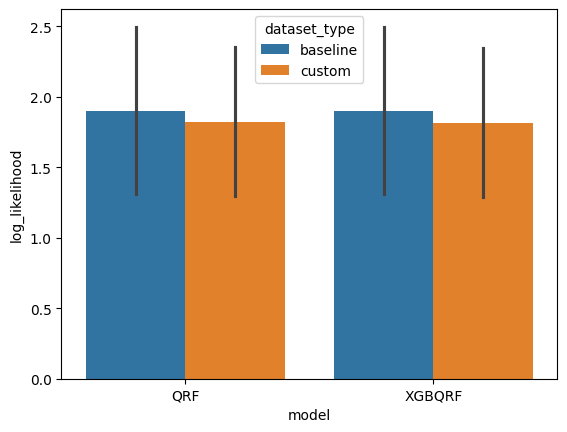

In [72]:
overall_results = pd.DataFrame()


for dataset_type in DATASET_TYPES:
    for i in range(NUMBER_OF_WEEK):
        t = compare_models_per_station(
            DATASETS[dataset_type]["y_eval"][0],
            predictions[dataset_type],
            DATASETS[dataset_type]["x_eval"]["station_code"].values,
            display=False,
            return_df=True,
        )
        t["dataset_type"] = dataset_type
        t["week"] = i
        overall_results = pd.concat([overall_results, t])

import seaborn as sns

sns.barplot(
    overall_results,
    x="model",
    y="log_likelihood",
    hue="dataset_type",
    errorbar="sd",
)

In [73]:
from scipy.stats import ttest_rel

baseline_log_likelihood = overall_results[
    (overall_results["dataset_type"] == "baseline")
]["log_likelihood"].values
custom_log_likelihood = overall_results[(overall_results["dataset_type"] == "custom")][
    "log_likelihood"
].values

min_len = min(len(baseline_log_likelihood), len(custom_log_likelihood))

baseline_log_likelihood = baseline_log_likelihood[:min_len]
custom_log_likelihood = custom_log_likelihood[:min_len]

stat, p_value = ttest_rel(custom_log_likelihood, baseline_log_likelihood)
print(
    f"Average log-likelihood for baseline : {baseline_log_likelihood.mean()} +/- {baseline_log_likelihood.std()}"
)
print(
    f"Average log-likelihood for custom : {custom_log_likelihood.mean()} +/- {custom_log_likelihood.std()}"
)
print("difference : ", custom_log_likelihood.mean() / baseline_log_likelihood.mean())
print("p-value:", p_value)

Average log-likelihood for baseline : 1.8937166771153253 +/- 0.5955032292635024
Average log-likelihood for custom : 1.8206457109892946 +/- 0.5291275916662141
difference :  0.961413992383835
p-value: 0.0020362182049074077


## CO2 emissions


baseline
{'QRF': {0: RandomForestQuantileRegressor(max_depth=30, max_features=None,
                              min_samples_leaf=20, min_samples_split=30,
                              n_estimators=130, random_state=42), 1: RandomForestQuantileRegressor(max_depth=30, max_features=None,
                              min_samples_leaf=20, min_samples_split=30,
                              n_estimators=130, random_state=42), 2: RandomForestQuantileRegressor(max_depth=30, max_features=None,
                              min_samples_leaf=20, min_samples_split=30,
                              n_estimators=130, random_state=42), 3: RandomForestQuantileRegressor(max_depth=30, max_features=None,
                              min_samples_leaf=20, min_samples_split=30,
                              n_estimators=130, random_state=42), 'predictions': {0: array([[  13.66      ,   29.02672143,   50.43928571],
       [   9.14385714,   20.20571429,   33.35817214],
       [   6.77428571,   12.3864285

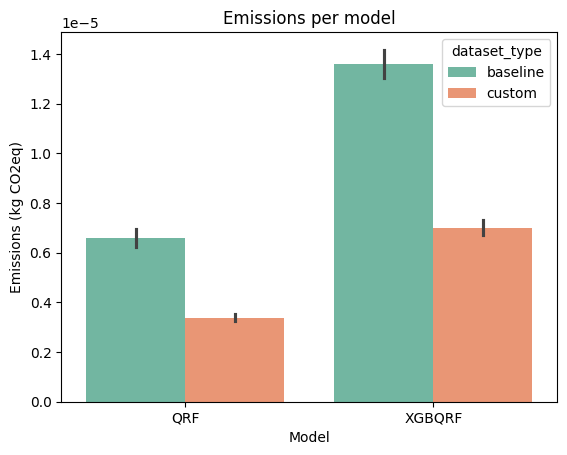

[codecarbon INFO @ 22:35:01] Energy consumed for RAM : 0.002925 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 22:35:01] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 22:35:01] Energy consumed for All CPU : 0.004876 kWh
[codecarbon INFO @ 22:35:01] 0.007801 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:35:31] Energy consumed for RAM : 0.002950 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 22:35:31] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 22:35:31] Energy consumed for All CPU : 0.004918 kWh
[codecarbon INFO @ 22:35:31] 0.007867 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:35:46] Energy consumed for RAM : 0.002962 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 22:35:46] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 22:35:46] Energy consumed for All CPU : 0.004938 kWh
[codecarbon INFO @ 22:35:46] 0.007901 kWh of ele

In [ ]:
emissions_rows = []
for dataset_type, dataset_data in summary.items():
    print(dataset_type)
    print(dataset_data)
    for model_type, emissions in dataset_data.get("emissions", {}).items():
        print(model_type, emissions)
        for emission in emissions:
            emissions_rows.append(
                {
                    "dataset_type": dataset_type,
                    "model_type": model_type,
                    "emission": emission,
                }
            )

emissions = pd.DataFrame(emissions_rows)

import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(
    emissions,
    x="model_type",
    y="emission",
    hue="dataset_type",
    errorbar="sd",
    palette="Set2",
)
plt.ylabel("Emissions (kg CO2eq)")
plt.xlabel("Model")
plt.title("Emissions per model")
plt.show()